In [ ]:
# Setup Spark SQL
# Note if running locally you need the JVM https://www.oracle.com/java/technologies/downloads/ 
# Consider running in https://colab.research.google.com/
%pip install pyspark

In [4]:
# Initialize Context - this is where you'd setup information about your Hadoop cluster if you had one!
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("Covid").getOrCreate()

sc = spark.sparkContext

sc.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 17:50:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Download 100mb covid county data file
!curl "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv" > ./uscounties.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  4 99.9M    4 4173k    0     0   147k      0  0:11:36  0:00:28  0:11:08  143k

In [28]:
# Read the file into a Spark DataFrame
usCountiesFilePath = "./uscounties.csv"

df = spark.read.csv(usCountiesFilePath, inferSchema=True, header=True)

df.show()

+----------+-----------+----------+-----+-----+------+
|      date|     county|     state| fips|cases|deaths|
+----------+-----------+----------+-----+-----+------+
|2020-01-21|  Snohomish|Washington|53061|    1|     0|
|2020-01-22|  Snohomish|Washington|53061|    1|     0|
|2020-01-23|  Snohomish|Washington|53061|    1|     0|
|2020-01-24|       Cook|  Illinois|17031|    1|     0|
|2020-01-24|  Snohomish|Washington|53061|    1|     0|
|2020-01-25|     Orange|California| 6059|    1|     0|
|2020-01-25|       Cook|  Illinois|17031|    1|     0|
|2020-01-25|  Snohomish|Washington|53061|    1|     0|
|2020-01-26|   Maricopa|   Arizona| 4013|    1|     0|
|2020-01-26|Los Angeles|California| 6037|    1|     0|
|2020-01-26|     Orange|California| 6059|    1|     0|
|2020-01-26|       Cook|  Illinois|17031|    1|     0|
|2020-01-26|  Snohomish|Washington|53061|    1|     0|
|2020-01-27|   Maricopa|   Arizona| 4013|    1|     0|
|2020-01-27|Los Angeles|California| 6037|    1|     0|
|2020-01-2

In [3]:
# SparkSQL API
df.createOrReplaceTempView("covid")  # create table that you can do sql on

print("Max deaths:")
spark.sql(
    """
    select county, state, deaths
    from covid
    order by deaths desc
    limit 1
  """
).show()

NameError: name 'df' is not defined

In [2]:
# DataFrame style
from pyspark.sql.functions import col, desc

print("Max deaths:")
print(
    df.orderBy(col("deaths").desc()).take(  # .where(col("county") == "New York City") \
        1
    )
)

Max deaths:


NameError: name 'df' is not defined

In [1]:
# RDD MapReduce Style without key
rows = df.rdd


def getMax(cumm, other):
    if other["deaths"] is not None and other["deaths"] > cumm["deaths"]:
        return other
    else:
        return cumm


print("Max deaths:")
print(rows.reduce(getMax))

NameError: name 'df' is not defined

In [34]:
# RDD MapReduce Style with mapped tuples
rows = df.rdd


def getMax(cumm, other):
    if other[0] > cumm[0]:
        return other
    else:
        return cumm


rows = rows.map(lambda r: (r["deaths"] or 0, f"{r['county']},{r['state']}"))
print("Max deaths:")
print(rows.reduce(getMax))

Max deaths:


(40267, 'New York City,New York')


In [41]:
# County with most deaths
spark = SparkSession.builder.appName("COVID Analysis").getOrCreate()

df = spark.read.option("header", True).csv("/Users/raulperbichi/Desktop/byu-cs-452-class-content/sparksql/uscounties.csv")

df = df.withColumn("deaths", col("deaths").cast("integer"))

df = df.na.fill(value=0, subset=["deaths"])

max_deaths_per_county = df.groupBy("county", "state").agg(spark_max("deaths").alias("max_deaths"))

county_with_max_deaths = max_deaths_per_county.orderBy(desc("max_deaths"))

county_with_max_deaths.select("county", "state", "max_deaths").show(1)

spark.stop()

+-------------+--------+----------+
|       county|   state|max_deaths|
+-------------+--------+----------+
|New York City|New York|     40267|
+-------------+--------+----------+
only showing top 1 row



In [54]:
# County with most cases
spark = SparkSession.builder.appName("COVID Case Analysis").getOrCreate()

df = spark.read.option("header", True).csv("/Users/raulperbichi/Desktop/byu-cs-452-class-content/sparksql/uscounties.csv")

df = df.withColumn("cases", col("cases").cast("integer"))

df = df.na.fill(value = 0, subset = ["cases"])

max_cases_per_county = df.groupBy("county", "state").agg(spark_max("cases").alias("max_cases"))

county_with_max_cases = max_cases_per_county.orderBy(desc("max_cases"))

county_with_max_cases.select("county", "state", "max_cases").show(1)

spark.stop()


+-----------+----------+---------+
|     county|     state|max_cases|
+-----------+----------+---------+
|Los Angeles|California|  2908425|
+-----------+----------+---------+
only showing top 1 row



In [50]:
# Number of deaths in Utah County
spark = SparkSession.builder.appName("Utah County COVID Analysis").getOrCreate()

df = spark.read.option("header", True).csv("/Users/raulperbichi/Desktop/byu-cs-452-class-content/sparksql/uscounties.csv")

df = df.withColumn("deaths", col("deaths").cast("integer"))

utah_county_deaths = df.filter((df.county == "Utah") & (df.state == "Utah"))

max_deaths = utah_county_deaths.groupBy("county", "state").agg(spark_max("deaths").alias("max_deaths"))

max_deaths.show()

spark.stop()

+------+-----+----------+
|county|state|max_deaths|
+------+-----+----------+
|  Utah| Utah|       791|
+------+-----+----------+



In [53]:
# State death reate analysis
spark = SparkSession.builder.appName("State Death Rate Analysis").getOrCreate()

df = spark.read.option("header", True).csv("/Users/raulperbichi/Desktop/byu-cs-452-class-content/sparksql/uscounties.csv")

df = df.withColumn("cases", col("cases").cast("integer"))\
       .withColumn("deaths", col("deaths").cast("integer"))\
       .na.fill(value=0, subset=["cases", "deaths"])

county_max = df.groupBy("county", "state").agg(
    spark_max("cases").alias("max_cases"),
    spark_max("deaths").alias("max_deaths")
)

state_totals = county_max.groupBy("state").agg(
    spark_sum("max_cases").alias("total_cases"),
    spark_sum("max_deaths").alias("total_deaths")
)

death_rate = state_totals.withColumn("death_rate", (col("total_deaths") / col("total_cases")) * 100)

sorted_death_rate = death_rate.orderBy(desc("death_rate"))

sorted_death_rate.show(sorted_death_rate.count(), truncate=False)

spark.stop()

+------------------------+-----------+------------+------------------+
|state                   |total_cases|total_deaths|death_rate        |
+------------------------+-----------+------------+------------------+
|Pennsylvania            |2850361    |44816       |1.572292071074506 |
|Mississippi             |801527     |12509       |1.5606461167247017|
|Alabama                 |1304721    |19629       |1.5044595741158455|
|Arizona                 |2030944    |30242       |1.4890612444262372|
|Nevada                  |745456     |10980       |1.4729239552703313|
|Georgia                 |2497983    |36748       |1.4711068890380758|
|Michigan                |2472824    |36153       |1.4620126624458514|
|New Jersey              |2316898    |33632       |1.4515960564513415|
|New Mexico              |526500     |7627        |1.4486229819563152|
|Ohio                    |2725342    |38572       |1.4153086108092123|
|Missouri                |1461727    |20588       |1.4084709388278387|
|Conne

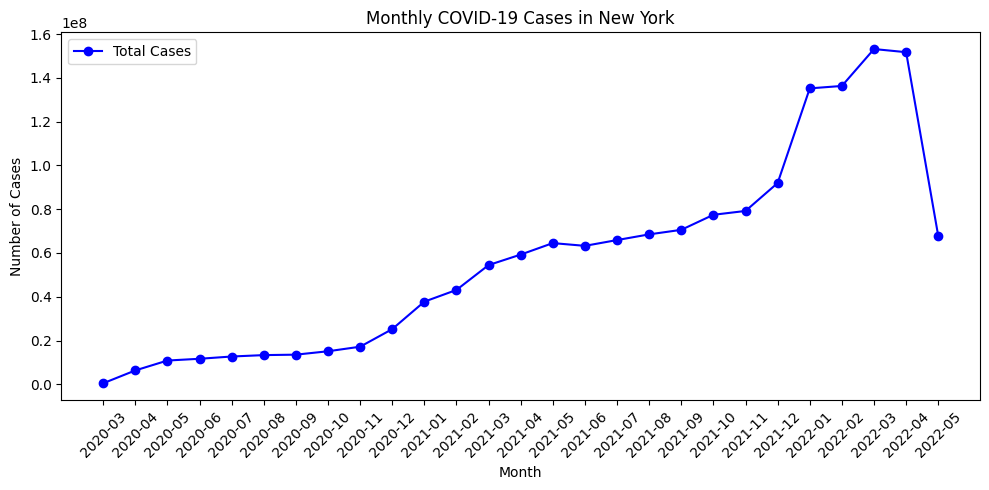

In [63]:
# Case trend analysis for New York
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("New York COVID Case Trend Analysis").getOrCreate()

df = spark.read.option("header", True).csv("/Users/raulperbichi/Desktop/byu-cs-452-class-content/sparksql/uscounties.csv")

df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))\
       .withColumn("cases", col("cases").cast("integer"))\
       .na.fill(value = 0, subset=["cases"])

ny_data = df.filter(df.state == "New York")

monthly_cases = ny_data.groupBy(year(col("date")).alias("year"), month(col("date")).alias("month"))\
                        .agg(spark_sum("cases").alias("total_cases"))\
                        .orderBy("year", "month")

result = monthly_cases.collect()

months = [f"{row['year']}-{row['month']:02d}" for row in result]
cases = [row['total_cases'] for row in result]

plt.figure(figsize = (10, 5))
plt.plot(months, cases, label='Total Cases', marker = 'o', color = 'b')
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.ylabel("Number of Cases")
plt.title("Monthly COVID-19 Cases in New York")
plt.legend()
plt.tight_layout()
plt.show()

spark.stop()
